
## Gradient boosting




- **Boosting** is an ensemble technique where learners are made sequentially, not independently, like that in Bagging.



- In **boosting**, the early learners fit simple models to data; then the residual errors are fitted by later learners.



- In **boosting**, subsequent predictors learn from the mistakes of the previous predictors.



- In doing so, **boosting** improves the complexity of the model and may lead to overfitting.  



- **Gradient Boosting** is specific to regression capable of finding hidden patterns.


##### Disadvantage:

- Because so much attention is put on correcting mistakes by the algorithm it is important that you have clean data with outliers removed.


- Overfitting needs to be checked.

- Careful tuning is required.

- Lots of hyperparameters and lack of transperancy!


- Cannot extrapolate


- Slow to train, fast to predict


In [ ]:

import os                                                   # to set current working directory
import math                                                 # basic calculations like square root
from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                              # for accessing tree information
from sklearn import metrics                                 # measures to check our models
from sklearn.tree import export_graphviz                    # graphical visualization of trees
from sklearn.preprocessing import StandardScaler            # standardize variables to mean of 0.0 and variance of 1.0

from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn.tree import DecisionTreeRegressor              # decision tree method
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor      # tree-based gradient boosting

import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call
import geostatspy.GSLIB as GSLIB                            # geostatistics and spat

#### Assisting functions



In [ ]:
def plot_corr(dataframe,size=10):                           # plots a graphical correlation matrix
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="white")
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    plt.title(title)                                       # add the labels
    plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z

def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

In [ ]:
# Access the data table from unconv_MV_v2.csv

from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/data_analytics/unconv_MV_v2.csv'

my_data = pd.read_csv("Data/unconv_MV_v2.csv")

Visualize the first several rows of data stored in a DataFrame to ensure we successfully loaded the data file.

In [ ]:
my_data.head(n=13)                                          # preview the first 13 rows of the DataFrame

,Sample,Por,LogPerm,AI,Brittle,TOC,VR,Production,Prod2Scaled
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958,1897.657798
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778,2745.732996
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583,5835.130524
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629,2132.237219
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919,6282.254735
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506,6443.694847
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285,2486.771344
7,8,14.15,1.23,2.53,39.43,0.79,1.54,1943.639213,2868.938662
8,9,16.18,1.34,3.45,45.79,0.56,1.95,3176.523611,4142.793216
9,10,20.51,2.48,2.78,28.99,1.78,2.24,2522.792318,4456.805225


In [ ]:
my_data = my_data.iloc[:,1:8]                            # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.769980,14.944955,3.030000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


It is good that we checked the summary statistics because we have some negative values for brittleness and total organic carbon. This is NOT realistic and they must be in error. So we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [ ]:
num = my_data._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                            # truncate negative values to 0.0
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.769980,14.944955,3.030000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Feature Ranges

Let's set predictor and response feature ranges for plotting.

In [ ]:
pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization
brittlemin = 0.0; brittlemax = 100.0
prodmin = 0.0; prodmax = 13000.0

#### Calculate the correlation matrix

For multivariate analysis it is a good idea to check the correlation matrix.

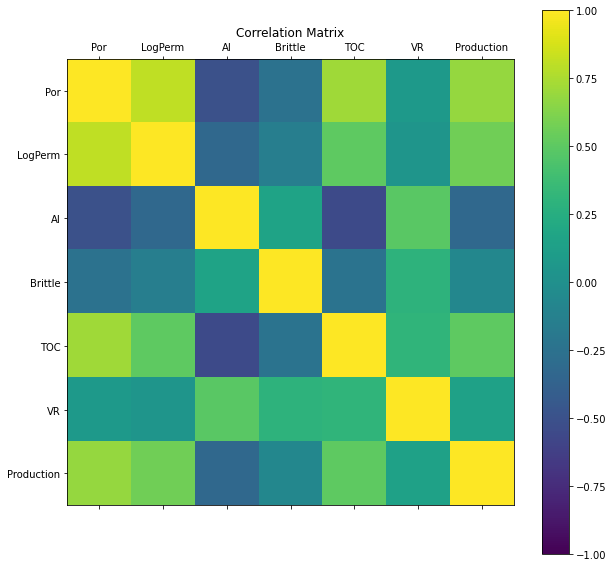

In [ ]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
#Let's use our function declared above to make a graphical correlation matrix visualization.
plot_corr(my_data,10)                                       # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plots.

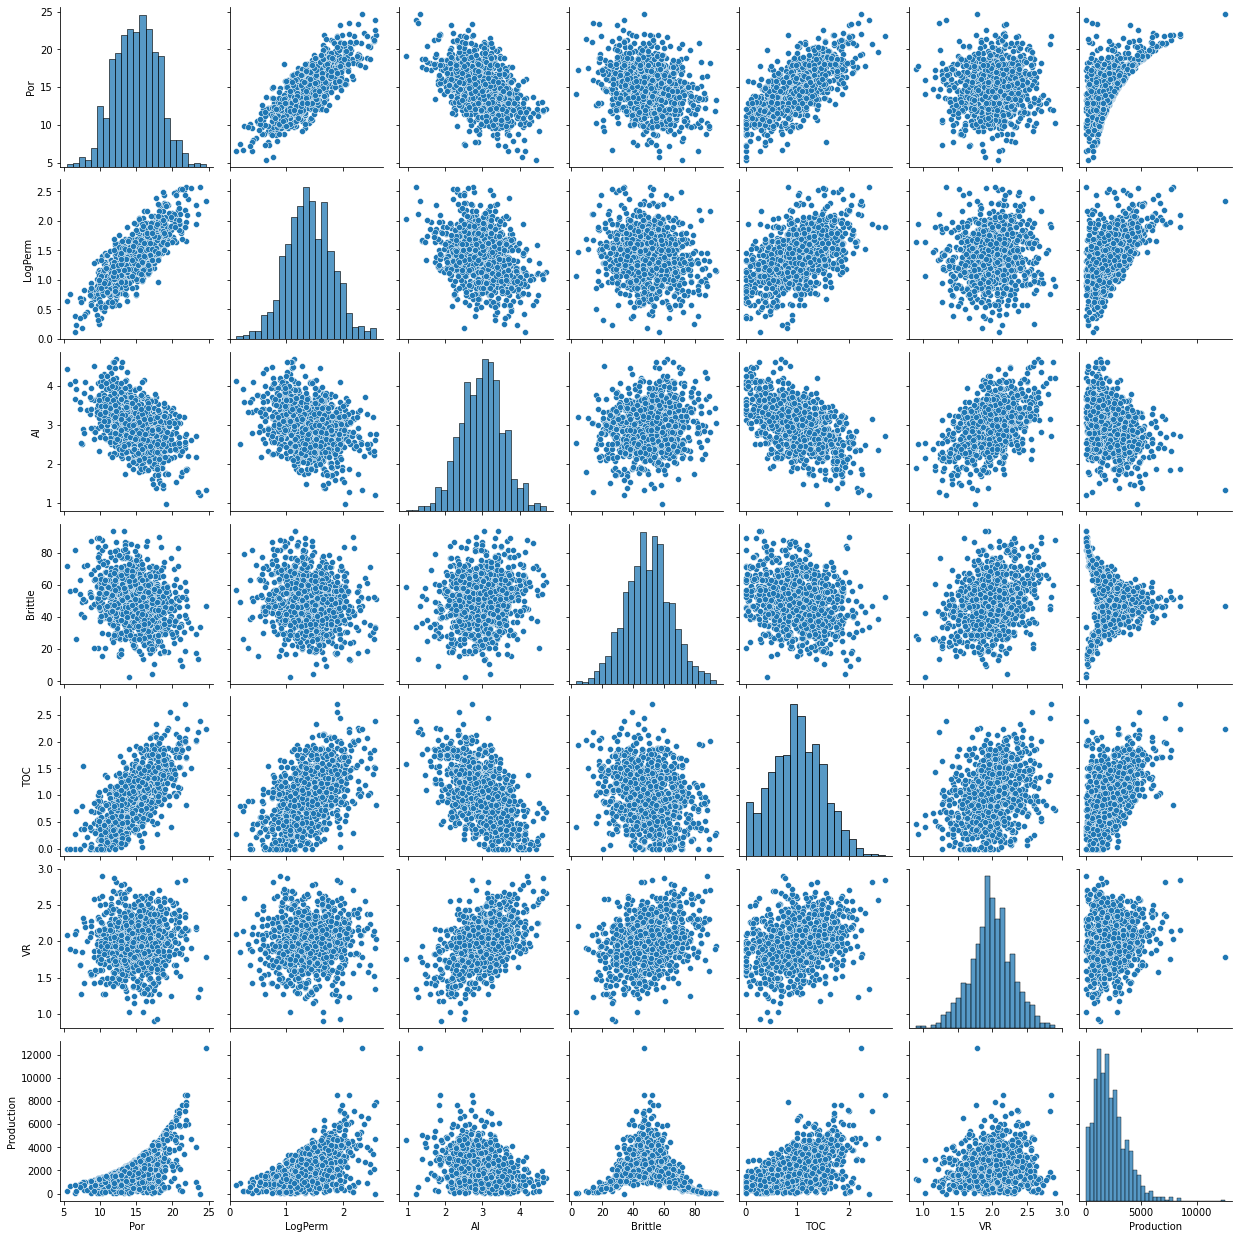

In [ ]:
import seaborn as sns
sns.pairplot(my_data)
plt.show()

#### Working with Only Two Features

Let's simplify the problem to two features (Porosity and Brittleness) to predict the Production rate.  
We will also reduce the number of wells from 1000 to 700 and withhold 300 for testing (simple cross-validation). By working with only two features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown entirely on a single plot).

In [ ]:
my_data_subset = my_data.iloc[:700,[0,3,6]]                 # extract just por, brittle and prod with 300 training samples
my_data_test_subset = my_data.iloc[700:,[0,3,6]]            # extract just por, brittle and prod with 700 testing samples
my_data_subset.describe().transpose()                       # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,700.0,14.990614,3.027982,5.400000,12.885000,15.070000,17.160000,23.850000
Brittle,700.0,50.028257,15.088983,4.500000,39.722500,49.580000,59.132500,93.470000
Production,700.0,2254.366506,1446.607602,2.713535,1199.891817,2027.464313,3063.130772,8554.267033


Let's examine a scatter plot of Porosity vs. Brittleness, with points colored by Production, for our testing and training data sets.

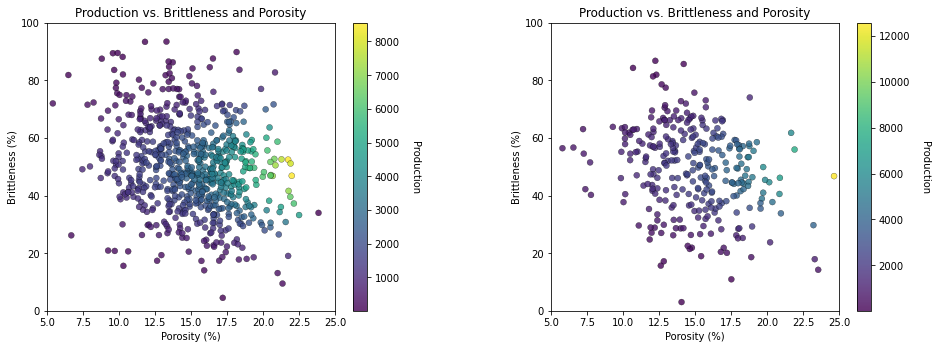

In [ ]:
plt.subplot(121)                                  # plot the training data
im = plt.scatter(my_data_subset["Por"],my_data_subset["Brittle"],s=None, c=my_data_subset["Production"], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
plt.xlim(pormin,pormax);plt.ylim(brittlemin,brittlemax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplot(122)                                # plot the training data
im = plt.scatter(my_data_test_subset["Por"],my_data_test_subset["Brittle"],s=None, c=my_data_test_subset["Production"], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
plt.xlim(pormin,pormax);plt.ylim(brittlemin,brittlemax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)
plt.show()

This problem looks complicated and could not be modeled using simple linear regression.  There seems to be a sweet spot for Brittleness, and increasing Porosity is always beneficial for Production.

#### Separate Predictor and Response Feature DataFrames

The input for the tree-based boosting is 2 DataFrames, one with the predictor features and the other with the response feature.  We will use the DataFrame member function copy() to copy the respective columns to 2 new DataFrames.

In [ ]:
predictors = my_data_subset[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
response = my_data_subset[['Production']].copy()            # make a new DataFrame with responses features for training
predictors_test = my_data_test_subset[['Por','Brittle']].copy() # make a new DataFrame with predictor features for testing
response_test = my_data_test_subset[['Production']].copy()  # make a new DataFrame with responses for testing

#### Tree-based Boosting

To perform tree-based boosting, we will:

. set the hyperparameters for our model

```python
params = {
    'loss': 'ls'                                            # L2 Norm - least squares
    'n_estimators': 1,                                      # number of trees
    'max_depth': 1,                                         # maximum depth per tree
    'learning_rate': 1,                                     
    'criterion': 'mse'                                      # tree construction criterion
}
```

* instantiate the model

```python
boost_tree = GradientBoostingRegressor(**params)

```

* train the the model

```python
boot_tree.fit(X = predictors, y = response)
```

* visualize the model result over the feature space (easy to do as we have only 2 predictor features)

#### Demonstration of Boosting

For demonstration let's set the number of trees to 1 and run 6 the tree-based boosting regressors.  

* each tree only has a single split, called decision stumps. This will prevent interaction between the predictor features and be highly interpretable

You should be able to observe the additive nature of the trees

* recall the estimate is the summation of multiple trees

* since we are working with fitting a gradient after the first tree, we can have negative and positive estimates

* in this example we can see some production estimates that are actually negative

#### Even though each tree is a simple stump (a tree with depth 1), the combination of multiple trees allows the model to make more complex predictions. Each tree is just a "correction" to the previous one.

Complete of 6:  1,  2,  3,  4,  5,  6,  

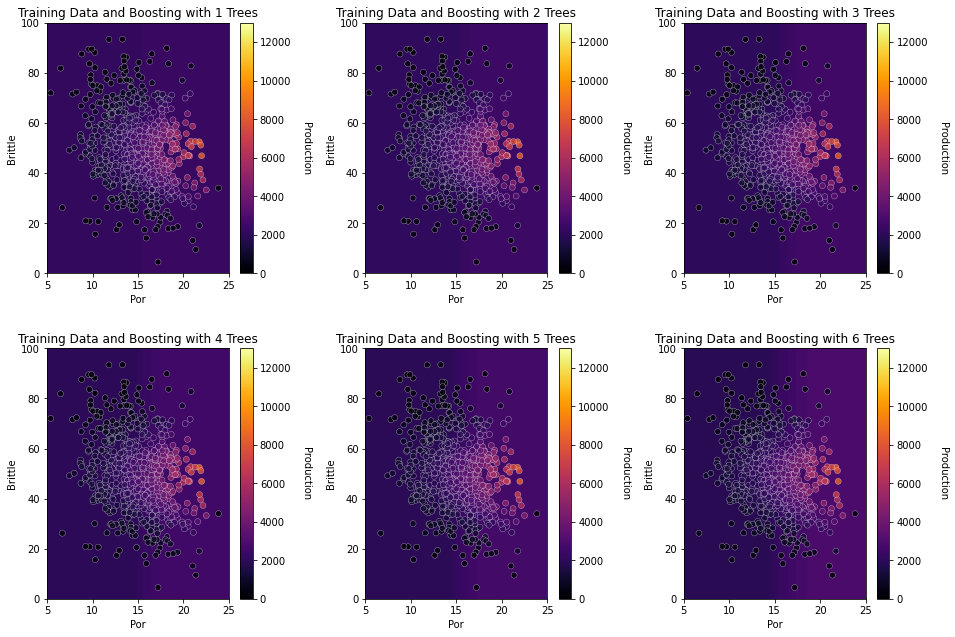

In [ ]:
import warnings
warnings.filterwarnings('ignore')                           # suppress warnings

params = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 1,
    'learning_rate': 0.1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

num_trees = np.linspace(1,6,6)                              # build a list of numbers of trees
boosting_models = []; score = []; pred = []                 # arrays for storage of models and model summaries

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))
    boosting_models[index-1].fit(X = predictors, y = response)
    score.append(boosting_models[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    pred.append(visualize_model(boosting_models[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees'))
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

Notice that there is a significant misfit with the data

* We have only used up to 6 decision stumps (1 decision tree)

Let's check the cross-validation results with the withheld testing data.

Complete of 6:  Mean Squared Error on Training =  2121684.4 , Variance Explained = 0.06 Cor = 0.25
1,  Mean Squared Error on Training =  2005375.22 , Variance Explained = 0.11 Cor = 0.34
2,  Mean Squared Error on Training =  1900100.32 , Variance Explained = 0.16 Cor = 0.4
3,  Mean Squared Error on Training =  1808364.72 , Variance Explained = 0.2 Cor = 0.45
4,  Mean Squared Error on Training =  1735869.12 , Variance Explained = 0.23 Cor = 0.48
5,  Mean Squared Error on Training =  1668801.51 , Variance Explained = 0.26 Cor = 0.51
6,  

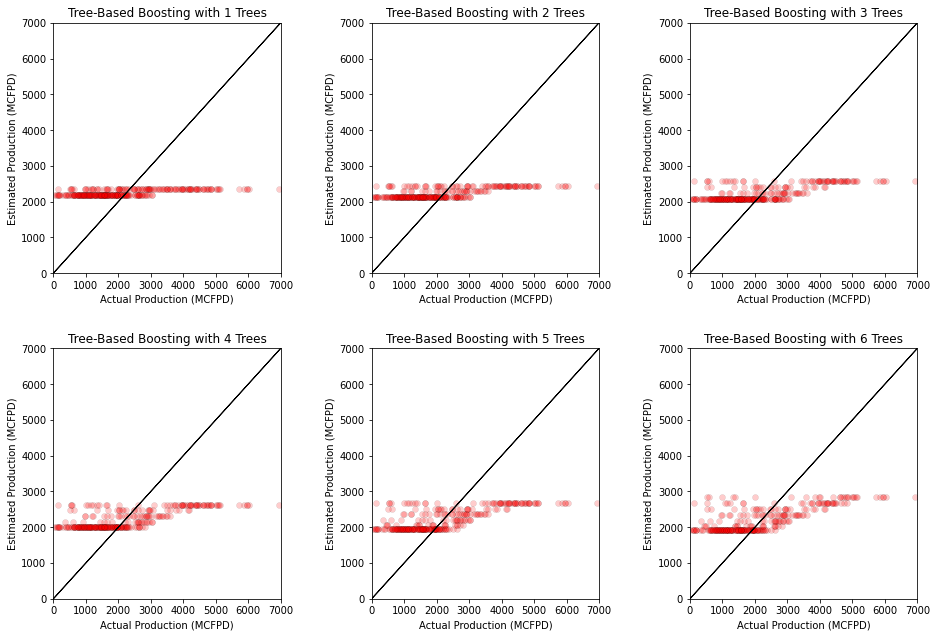

In [ ]:
index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    plt.subplot(2,3,index)
    check_model(boosting_models[index-1],my_data_test_subset["Por"],my_data_test_subset["Brittle"],my_data_test_subset["Production"],'Tree-Based Boosting with ' + str(int(num_tree)) + ' Trees')
    print(str(index)+ ', ', end =" ")
    index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

Of course, with a single tree, we do quite poorly, but by the time we get to 6 stump trees, improving the prediction is not bad for quite a simple model.

#### Time to Build More Trees

Now let's demonstrate the result of using many more trees in our tree-based boosting model.

* We will still work with simple decision stumps. We will add more later.

Complete of 6:  1,  2,  3,  4,  5,  6,  

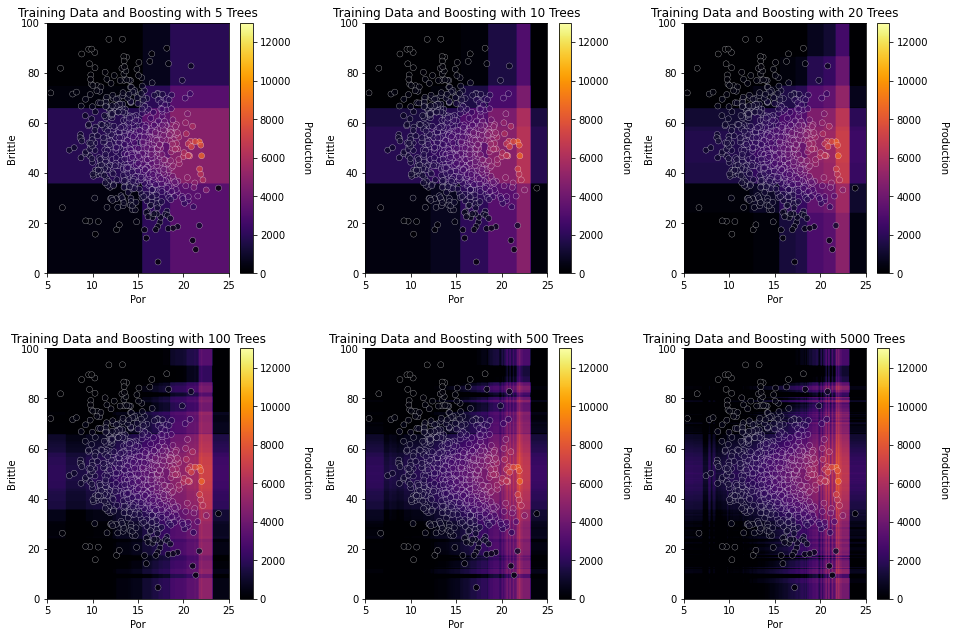

In [ ]:
import warnings
warnings.filterwarnings('ignore')                           # suppress warnings

params = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 1,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

num_trees = [5,10,20,100,500,5000]                          # build a list of numbers of trees
boosting_models = []; score = []; pred = []                 # arrays for storage of models and model summaries

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))
    boosting_models[index-1].fit(X = predictors, y = response)
    score.append(boosting_models[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    pred.append(visualize_model(boosting_models[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees'))
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

See the plaid pattern? It is due to the use of decision stumps and:

* an additive model
* all models contribute to all predictions

See the blank spots

* that our model predicts negative values, the additive model may extrapolate outside the data range

Let's cross validate with our testing data to see how our model has improved with more trees.

Complete of 6:
  1,  Mean Squared Error on Training =  745578.87 , Variance Explained = 0.67 Cor = 0.82
2,  Mean Squared Error on Training =  876674.43 , Variance Explained = 0.62 Cor = 0.78
3,  Mean Squared Error on Training =  680466.67 , Variance Explained = 0.7 Cor = 0.84
4,  Mean Squared Error on Training =  566751.11 , Variance Explained = 0.75 Cor = 0.87
5,  Mean Squared Error on Training =  596828.95 , Variance Explained = 0.74 Cor = 0.86
6,  Mean Squared Error on Training =  685768.78 , Variance Explained = 0.7 Cor = 0.83


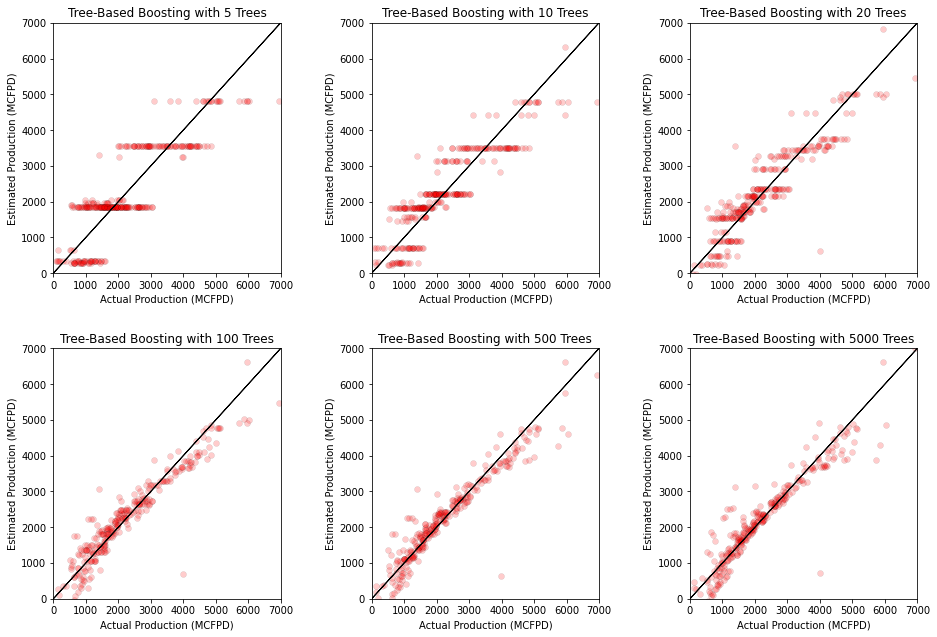

In [ ]:
index = 1
print('Complete of ' + str(len(num_trees)) + ':\n ', end =" ");
for num_tree in num_trees:                                  # loop over number of trees
    plt.subplot(2,3,index)
    print(str(index)+ ', ', end =" ")
    check_model(boosting_models[index-1],my_data_test_subset["Por"],my_data_test_subset["Brittle"],my_data_test_subset["Production"],'Tree-Based Boosting with ' + str(int(num_tree)) + ' Trees')
    #print(str(index)+ ', ', end =" ")
    index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

Around 20 trees, we get our best performance, and then we start to degrade; we are likely beginning to overfit the training data.

#### Going Beyond Decision Stumps

As stated before, with decision stumps, we prevent interactions between features.

Let's extend to a tree depth of 2

* two nested decisions resulting in 4 terminal nodes

We will repeat the previous model run with $1,\ldots,6$ trees for comparison and ease of visualization.

Complete of 6:  1,  2,  3,  4,  5,  6,  

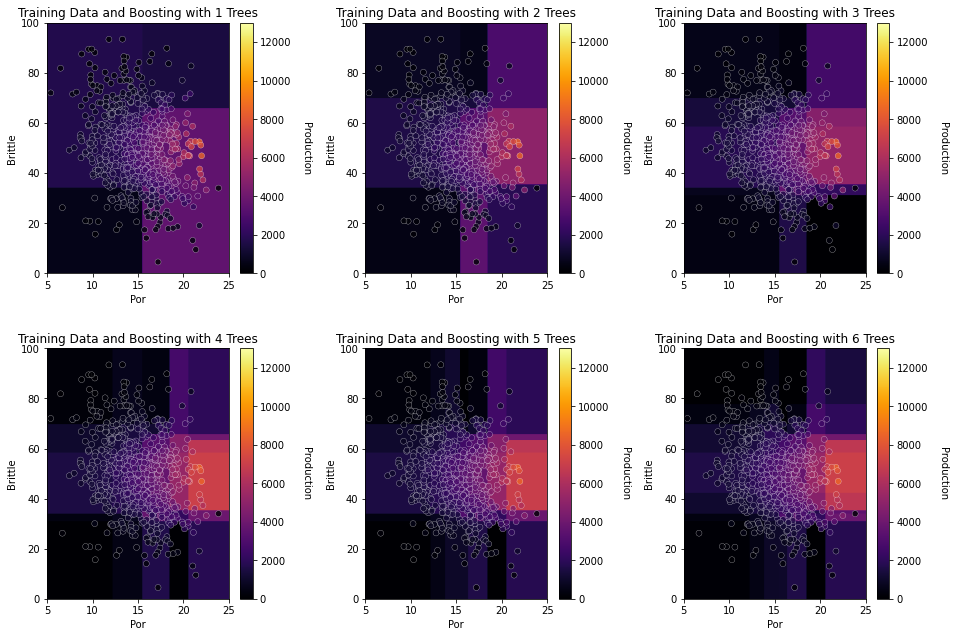

In [ ]:
params = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 2,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

num_trees = np.linspace(1,6,6)
boosting_models = []; score = []; pred = []

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))
    boosting_models[index-1].fit(X = predictors, y = response)
    score.append(boosting_models[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    pred.append(visualize_model(boosting_models[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees'))
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

We have much more flexibility now.  

* with one tree, we have 4 terminal nodes (regions)

* with only 6 trees, we are capturing some complicated features

Let's increase the tree depth one more time and once again repeat with models of $1,\ldots,6$ trees

Complete of 6:  1,  2,  3,  4,  5,  6,  

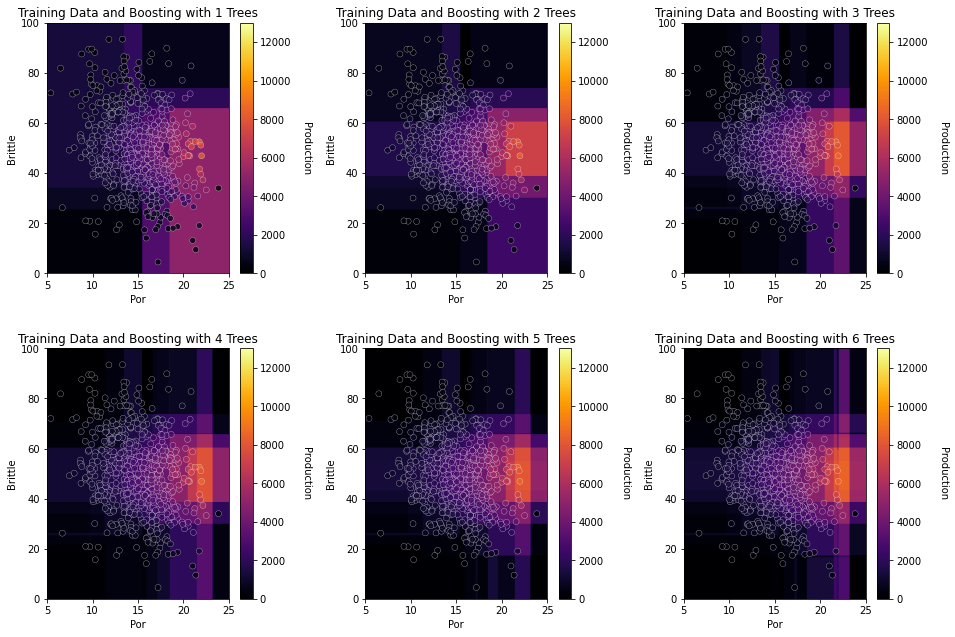

In [ ]:
params = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 3,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

num_trees = np.linspace(1,6,6)
boosting_models = []; score = []; pred = []

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))
    boosting_models[index-1].fit(X = predictors, y = response)
    score.append(boosting_models[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    pred.append(visualize_model(boosting_models[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees'))
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

One more time, it is common to use trees with depths of 4-8, so let's try 5.

Complete of 6:  1,  2,  3,  4,  5,  6,  

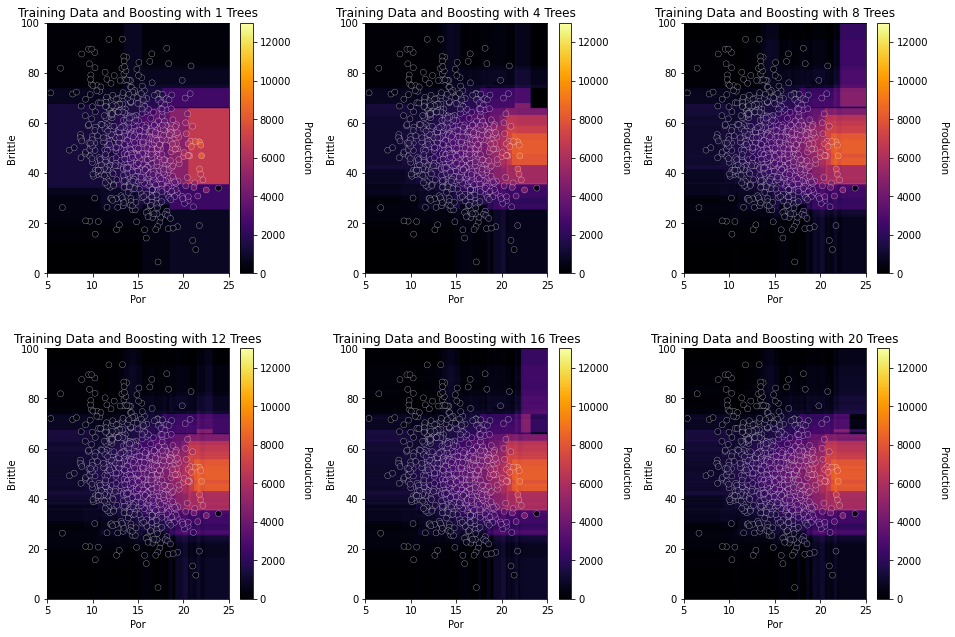

In [ ]:
params = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 5,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

num_trees = np.linspace(1,20,6)
boosting_models = []; score = []; pred = []

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))
    boosting_models[index-1].fit(X = predictors, y = response)
    score.append(boosting_models[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    pred.append(visualize_model(boosting_models[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees'))
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

With only 8 trees we are now fitting the training data quite well.  Let's cross validate the model with testing data.

Complete of 6:
 1,  Mean Squared Error on Training =  345995.84 , Variance Explained = 0.85 Cor = 0.92
2,  Mean Squared Error on Training =  209960.36 , Variance Explained = 0.91 Cor = 0.95
3,  Mean Squared Error on Training =  188190.61 , Variance Explained = 0.92 Cor = 0.96
4,  Mean Squared Error on Training =  164960.31 , Variance Explained = 0.93 Cor = 0.96
5,  Mean Squared Error on Training =  166082.49 , Variance Explained = 0.93 Cor = 0.96
6,  Mean Squared Error on Training =  176161.67 , Variance Explained = 0.92 Cor = 0.96


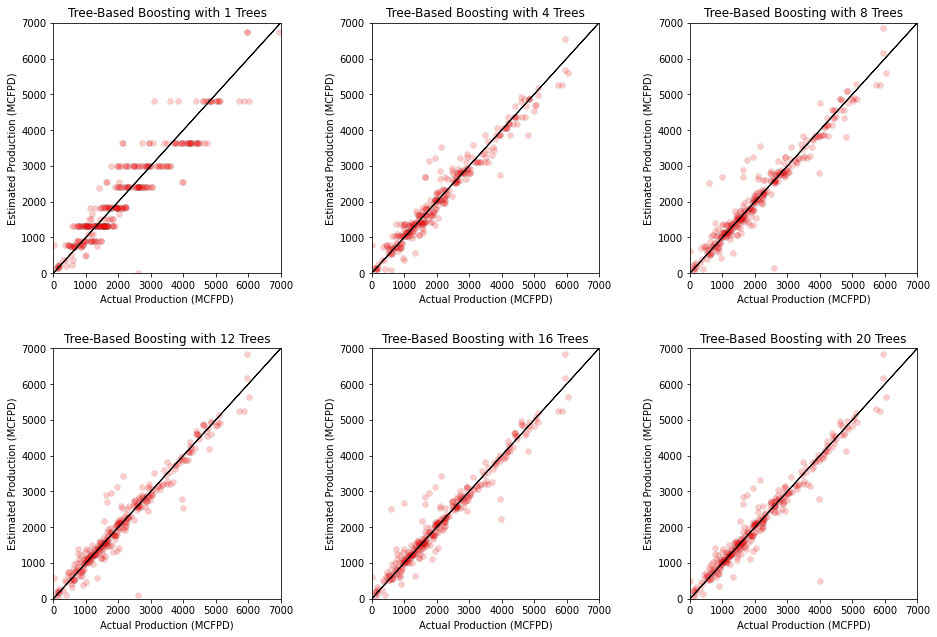

In [ ]:
index = 1
print('Complete of ' + str(len(num_trees)) + ':\n', end =" ")
for num_tree in num_trees:                                  # loop over number of trees
    plt.subplot(2,3,index)
    print(str(index)+ ', ', end =" ")
    check_model(boosting_models[index-1],my_data_test_subset["Por"],my_data_test_subset["Brittle"],my_data_test_subset["Production"],'Tree-Based Boosting with ' + str(int(num_tree)) + ' Trees')
    index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

With a max tree depth of 5, our model performance peaks early, and adding more trees has no impact.

* of course, this is not a thorough analysis

Let's try something more thorough

* we will cross validate models with $1,\ldots,100$ trees with max tree depths of $1, 2, 3, 10$.

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

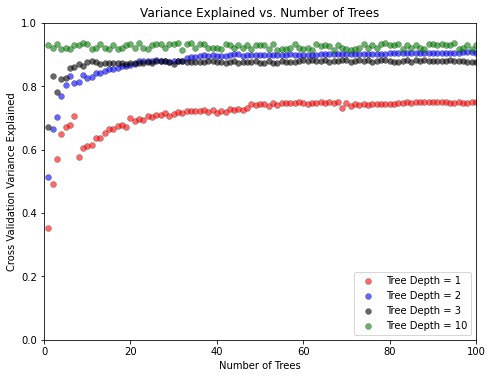

In [ ]:
num_trees = np.linspace(1,100,100)
max_features = 1
boosting_models1 = []; boosting_models2 = []; boosting_models3 = []; boosting_models4 = []
score1 = []; score2 = []; score3 = []; score4 = []

params1 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 1,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

params2 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 2,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

params3 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 3,                                         # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

params4 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 10,                                        # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees in our random forest
    boosting_models1.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params1))
    boosting_models1[index-1].fit(X = predictors, y = response)
    score1.append(boosting_models1[index-1].score(X = predictors_test, y = response_test))

    boosting_models2.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params2))
    boosting_models2[index-1].fit(X = predictors, y = response)
    score2.append(boosting_models2[index-1].score(X = predictors_test, y = response_test))

    boosting_models3.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params3))
    boosting_models3[index-1].fit(X = predictors, y = response)
    score3.append(boosting_models3[index-1].score(X = predictors_test, y = response_test))

    boosting_models4.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params4))
    boosting_models4[index-1].fit(X = predictors, y = response)
    score4.append(boosting_models4[index-1].score(X = predictors_test, y = response_test))

    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplot(111)                                            # plot jackknife results for all cases
plt.scatter(num_trees,score1,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Tree Depth = 1")
plt.scatter(num_trees,score2,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Tree Depth = 2")
plt.scatter(num_trees,score3,s=None, c='black', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Tree Depth = 3")
plt.scatter(num_trees,score4,s=None, c='green', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Tree Depth = 10")

plt.title('Variance Explained vs. Number of Trees'); plt.xlabel('Number of Trees'); plt.ylabel('Cross Validation Variance Explained')
plt.xlim(0,100); plt.ylim(0,1.0); plt.legend(loc='lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

Higher percentages of explained variance indicate a stronger strength of association. It also means that you make better predictions (Rosenthal & Rosenthal, 2011).

That's interesting:

* with increasing tree depths, our model may improve

* more tree depth requires fewer trees for improved accuracy

* with tree depths of 2 and 3, the models behave the same and after 10-15 trees level off, they are resistant to overfit

* with a tree depth of 10, the number of trees has no impact on the model performance

Recall the response feature is non-linear, but smooth over the predictor feature space

#### Gradient Descent Hyperparameters

The learning rate scales the additive impact of each additive tree to the overall model prediction.

* lower learning rate will slow the convergence to a solution

* lower learning rate will help us not skip over an optimum solution

We won't spend much time on this, but let's just try changing the learning rate.

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

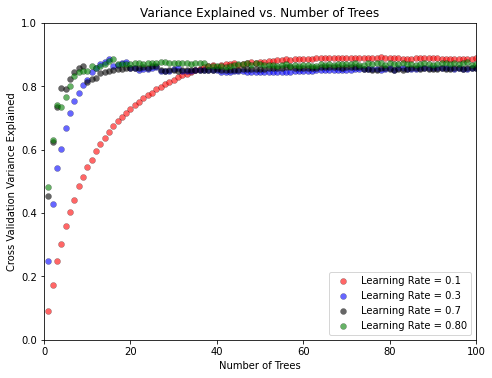

In [ ]:
num_trees = np.linspace(1,100,100)
max_features = 1
boosting_models1 = []; boosting_models2 = []; boosting_models3 = []; boosting_models4 = []
score1 = []; score2 = []; score3 = []; score4 = []

params1 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 2,                                         # maximum depth per tree
    'learning_rate': 0.1,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

params2 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 2,                                         # maximum depth per tree
    'learning_rate': 0.3,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

params3 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 2,                                         # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

params4 = {
    'loss': 'ls',                                           # L2 Norm - least squares
    'max_depth': 2,                                         # maximum depth per tree
    'learning_rate': 0.80,
    'criterion': 'mse'                                      # tree construction criteria is mean square error over training
}

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees in our random forest
    boosting_models1.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params1))
    boosting_models1[index-1].fit(X = predictors, y = response)
    score1.append(boosting_models1[index-1].score(X = predictors_test, y = response_test))

    boosting_models2.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params2))
    boosting_models2[index-1].fit(X = predictors, y = response)
    score2.append(boosting_models2[index-1].score(X = predictors_test, y = response_test))

    boosting_models3.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params3))
    boosting_models3[index-1].fit(X = predictors, y = response)
    score3.append(boosting_models3[index-1].score(X = predictors_test, y = response_test))

    boosting_models4.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params4))
    boosting_models4[index-1].fit(X = predictors, y = response)
    score4.append(boosting_models4[index-1].score(X = predictors_test, y = response_test))

    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplot(111)                                            # plot jackknife results for all cases
plt.scatter(num_trees,score1,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.1")
plt.scatter(num_trees,score2,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.3")
plt.scatter(num_trees,score3,s=None, c='black', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.7")
plt.scatter(num_trees,score4,s=None, c='green', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.80")

plt.title('Variance Explained vs. Number of Trees'); plt.xlabel('Number of Trees'); plt.ylabel('Cross Validation Variance Explained')
plt.xlim(0,100); plt.ylim(0,1.0); plt.legend(loc='lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

Once again, an interesting result.

* decreasing learning rate, requires more trees to reach the variance explained plateau


# Extreme gradient boosting

- XGBoost is a more regularized form of Gradient Boosting. XGBoost uses L1 and L2 regularization, which improves model generalization and reduces overfitting.
- As previously discussed under the gradient boosting section, the error rate of a gradient boosting model is used to calculate the gradient, which is essentially the partial derivative of the loss function. In contrast, XGBoost uses the second partial derivative of the loss function. Using the second partial derivative of the loss function will provide more info about the direction of the gradient.

- XGBoost is usually faster than gradient boosting due to the parallelization of tree construction.

- XGBoost can handle missing values within a data set; therefore, the data preparation is not as time-consuming.

#### When to use XGBoost?
1) When there is a larger number of training samples. Ideally, more than 1000 training samples and less than 100 features or when we can say when the number of features < number of training samples.

2) When there is a mixture of categorical and numeric features or just numeric features.

In [ ]:
#X_train
predictors = my_data_subset[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
#y_train
response = my_data_subset[['Production']].copy()            # make a new DataFrame with responses features for training
#X_test
predictors_test = my_data_test_subset[['Por','Brittle']].copy() # make a new DataFrame with predictor features for testing
#y_test
response_test = my_data_test_subset[['Production']].copy()  # make a new DataFrame with responses for testing

In [ ]:
#!pip install xgboost
from xgboost import XGBRegressor

In [ ]:
seed= 1000
np.random.seed(seed)
xgb=XGBRegressor(objective ='reg:squarederror',n_estimators=200, reg_lambda=1, gamma=0,max_depth=3,
                 learning_rate = 0.1, reg_alpha = 0.1)

In [ ]:
xgb.fit(X = predictors, y = response)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred_train=xgb.predict(predictors)
y_pred_test=xgb.predict(predictors_test)

In [ ]:
#convert dataframe into 1d numpy array
response=response.values.ravel()
response_test=response_test.values.ravel()

In [ ]:
corr_train=np.corrcoef(response, y_pred_train) [0,1]

print('Training Data R^2=',round(corr_train**2,4),'R=', round(corr_train,4))

Training Data R^2= 0.9973 R= 0.9986


In [ ]:
corr_test=np.corrcoef(response_test, y_pred_test) [0,1]

print('Testing Data R^2=',round(corr_test**2,4),'R=', round(corr_test,4))

Testing Data R^2= 0.8776 R= 0.9368


Text(0.5, 1.0, 'Production Training Actual Vs. Prediction')

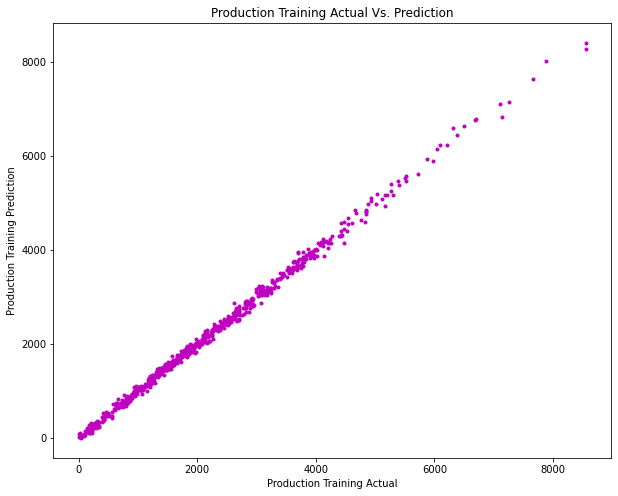

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(response, y_pred_train, 'm.')
plt.xlabel('Production Training Actual')
plt.ylabel('Production Training Prediction')
plt.title('Production Training Actual Vs. Prediction')

Text(0.5, 1.0, 'Production Testing Actual Vs. Prediction')

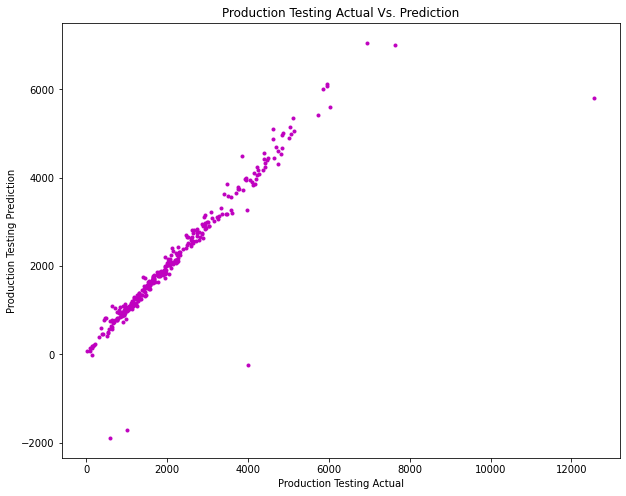

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(response_test, y_pred_test, 'm.')
plt.xlabel('Production Testing Actual')
plt.ylabel('Production Testing Prediction')
plt.title('Production Testing Actual Vs. Prediction')

In [ ]:
from sklearn import metrics
print('MAE:', round(metrics.mean_absolute_error(response_test, y_pred_test),5))
print('MSE:', round(metrics.mean_squared_error(response_test, y_pred_test),5))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(response_test, y_pred_test)),5))

MAE: 157.77301
MSE: 279742.47956
RMSE: 528.90687


Text(0.5, 1.0, 'Feature Importance Ranking')

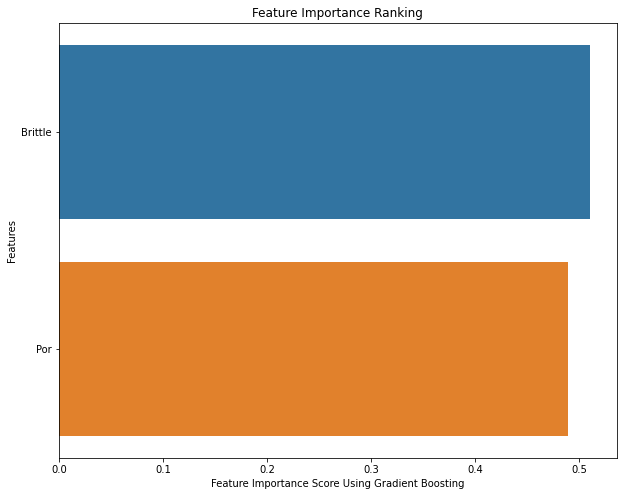

In [ ]:
feature_names = my_data_subset.columns[:-1]
plt.figure(figsize=(10,8))
feature_imp = pd.Series(xgb.feature_importances_,index=feature_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score Using Gradient Boosting')
plt.ylabel('Features')
plt.title("Feature Importance Ranking")

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
x = my_data[['Por','Brittle']].copy()
y = my_data[['Production']].copy()

In [ ]:
np.random.seed(seed)
scores_R2 = cross_val_score(xgb, x, y,cv=10,scoring='r2')

In [ ]:
print(" R2_Cross-validation scores: {}". format( scores_R2))

 R2_Cross-validation scores: [0.99011148 0.85126476 0.97303323 0.98756991 0.99011964 0.98848081
 0.98691919 0.81377419 0.98835649 0.98934472]


In [ ]:
print(" Average R2_Cross-validation scores: {}". format( scores_R2.mean()))

 Average R2_Cross-validation scores: 0.955897442667152


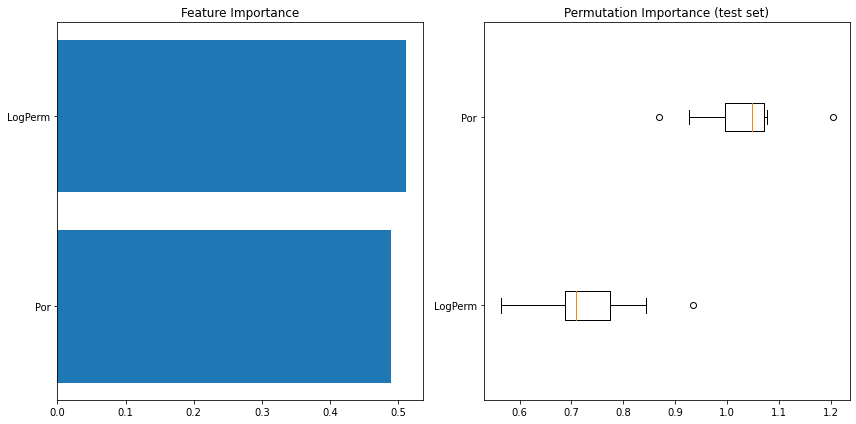

In [ ]:
from sklearn.inspection import permutation_importance
feature_importance = xgb.feature_importances_
sorted_features = np.argsort(feature_importance)
pos = np.arange(sorted_features.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_features], align='center')
plt.yticks(pos, np.array(my_data.columns)[sorted_features])
plt.title('Feature Importance')

result = permutation_importance(xgb, predictors_test, response_test, n_repeats=10,random_state=seed)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(my_data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()